In [1]:
import numpy as np
import ffttools as fftt
import utils
import generate
from wgmca import wGMCA

np.random.seed(1)
plt.rcParams.update({'font.size': 16})

# Data parameters

In [2]:
n = 4                       # number of sources
m = 8                       # number of observations/channels
size = 128                  # size of the sources (size * size images)
nscales = 3                 # source generation: number of wavelet transform (WT) scales
condn = 2                   # mixing matrix generation: matrix condition number
F_max = 1420                # highest frequency, in MHz
resolution_ratio = 0.2      # lowest frequency, w.r.t the highest (F_min = resolution_ratio * F_max)
pixel_scale = 5/60/size     # in arcsec (here, it corresponds to a 5° FoV, ie. 2.3' per pixel)
w_max = 1e6               # maximum w-value (necessarily at F_max)
n_stacks = 11               # number of samples of the w-axis grid, should be an odd integer
sigma_uv = size / 6         # interferometer's response: dispersion along the u & v axes
sigma_w = n_stacks / 6      # interferometer's response: dispersion along the w axis
alpha_vis = 0.1             # interferometer's response: mask support, as a ratio (0 < alpha_vis <= 1)
snr = 30                    # data SNR in dB
verb = 1                    # verbosity (from 0 [mute] to 5 [very talkative])

# Deduce other parameters
l_max = np.sin(pixel_scale*60/180*np.pi) 
min_n_stacks = 2 * np.pi * 2 * w_max * (1 - np.sqrt(1 - 2 * l_max ** 2))
if 10 * min_n_stacks > n_stacks:
    print("Beware, number of w-stacks is not realistic.")

Beware, number of w-stacks is not realistic.


# Generate data
## 1. Generate the sources and the mixing matrix

In [3]:
# Define the sources
S0 = generate.generate_sources(n=n, size=size, nscales=3, cutmin=int(size/4), cutmax=int(size*3/4), sparseLvl=3)

# Define the mixing matrix
A0 = generate.generate_mixmat(n=n, m=m, condn=condn, max0s=0)

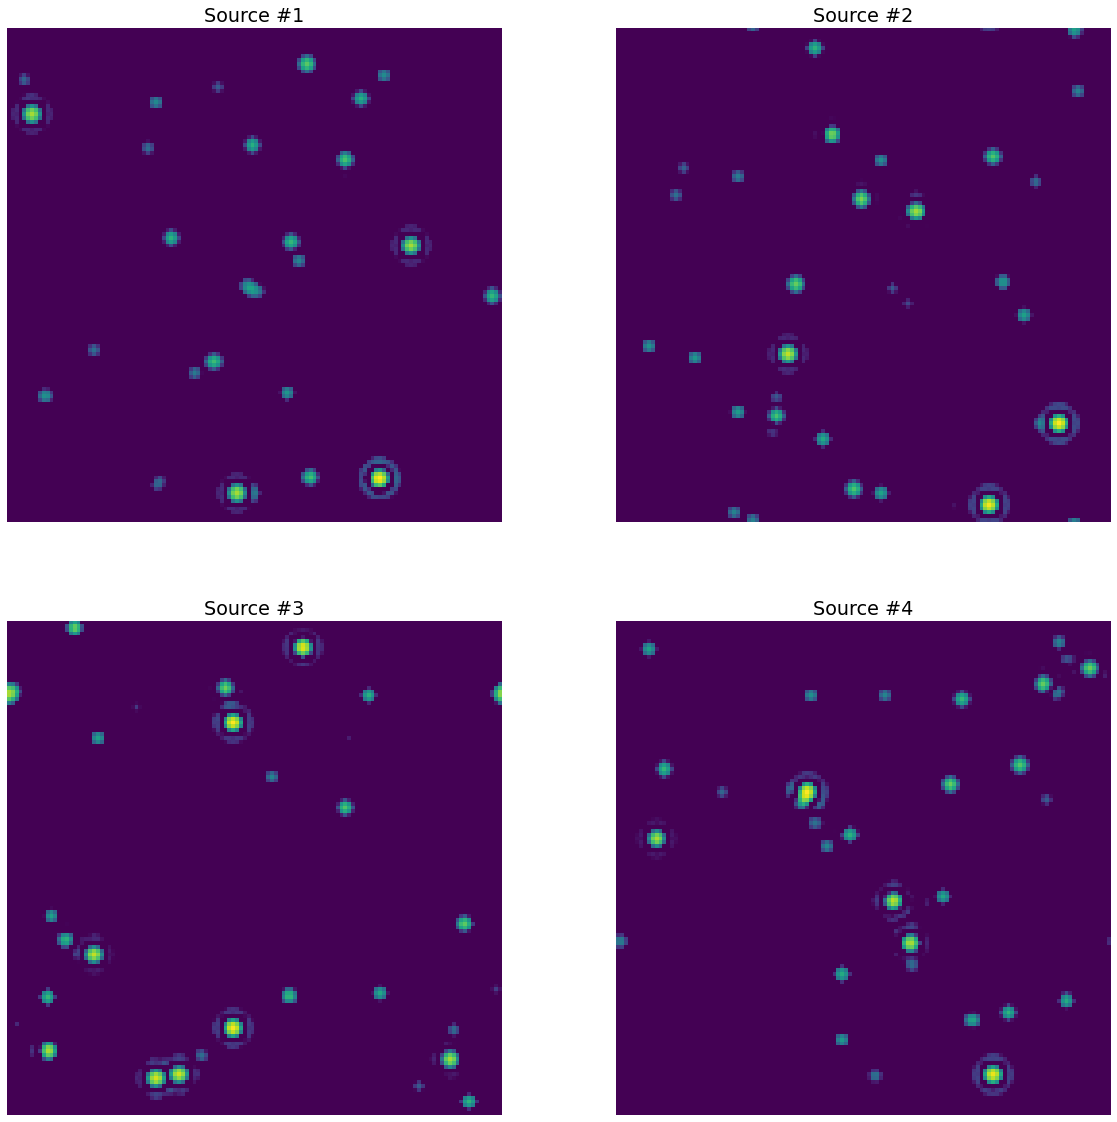

In [4]:
# Plot the sources

vmin = 1e-2

def f(x):
    return np.log10(np.maximum(vmin,x))

fig = plt.figure(figsize=(20,20))
for i, j in enumerate(range(221, 225)):
    fig.add_subplot(j)
    plt.imshow(np.reshape(f(S0[i, :]), (size, size)))
    plt.title('Source #%i' % (i+1))
    plt.gca().set_axis_off()

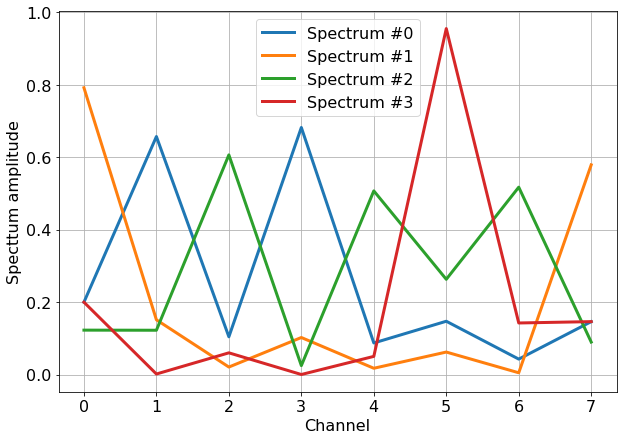

In [5]:
# Plot the mixing matrix

plt.figure(figsize=(10,7))
for i in range(n):
    plt.plot(A0[:, i], linewidth=3, label='Spectrum #%i' % i)
plt.grid()
plt.legend()
plt.xlabel('Channel')
plt.ylabel('Specttum amplitude');

## 2. Define the interferometer response

The interferometer response `H` is a combination of Gaussian kernels and random masks. 

### 2.1 Generate the Gaussian kernels

In [6]:
H = generate.generate_gaussian_filters(m, size, size / 4 * resolution_ratio, size / 4)  

H_reconv = H[-1]  # kernel of F_min, it is needed for wGMCA

### 2.2 Generate the masks

In [7]:
masks = generate.generate_masks(m, size, n_stacks, alpha_vis, sigma_uv, sigma_w, resolution_ratio)

### 2.3 Deduce the interferometer response
Apply an element-wise product of the Gaussian kernels and the masks.

In [8]:
H = np.repeat(H[:, np.newaxis, :], n_stacks, axis=1)
H *= masks

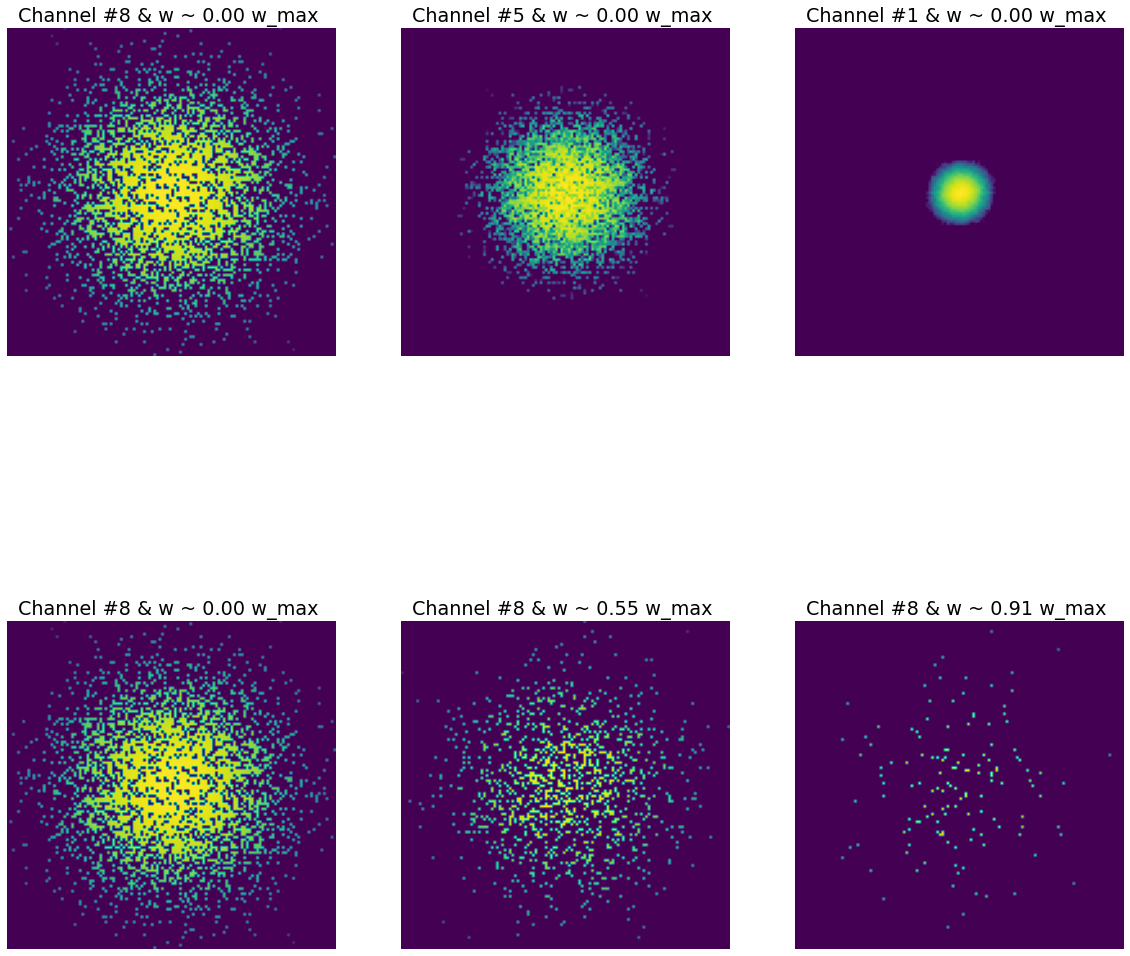

In [9]:
# Plot the interferometer response H at different frequencies and w-values

selection = [[m-1, n_stacks//2], [m//2, n_stacks//2], [0, n_stacks//2],
            [m-1, n_stacks//2], [m-1, int(3*n_stacks/4)], [m-1, n_stacks-1]]
w = np.linspace(-w_max, w_max, 2 * n_stacks + 1)[1:-1:2]

fig = plt.figure(figsize=(20,20))
for i, j in enumerate(range(231, 237)):
    fig.add_subplot(j)
    plt.imshow(np.reshape(f(H[selection[i][0], selection[i][1], :]), (size, size)))
    plt.title('Channel #%i & w ~ %.2f w_max ' % (selection[i][0]+1, w[selection[i][1]]/w_max))
    plt.gca().set_axis_off()

## 3. Get the w-term matrices

In [10]:
G = generate.generate_w_matrices(size, l_max, n_stacks, w_max)

Beware, number of stacks considered is not realistic.


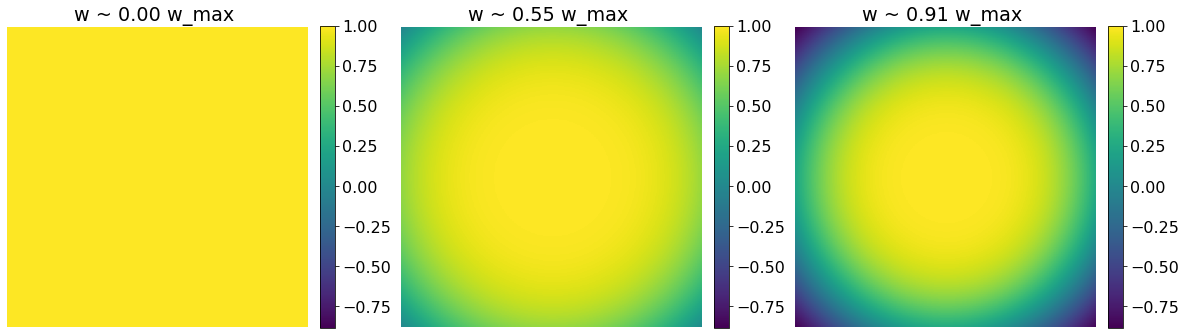

In [11]:
# Plot the (real part of the) w-term matrices

selection = [n_stacks//2, int(n_stacks*3/4), n_stacks-1]

fig = plt.figure(figsize=(20,20))
for i, j in enumerate(range(131, 134)):
    fig.add_subplot(j)
    plt.imshow(np.reshape(np.real(G[selection[i]]), (size, size)), vmin=np.min(np.real(G)), vmax=1)
    plt.title('w ~ %.2f w_max ' % (w[selection[i]]/w_max))
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.gca().set_axis_off()

## 4. Generate the noisy data

In [12]:
# Calculate the data with no noise
X = H * np.einsum('ij,jkl', A0, fftt.fft(G[np.newaxis, ...] * S0[:, np.newaxis, :]))

In [13]:
# Generate complex noise, which verifies some conjugate-symmetry proprieties
Var = H  # noise variance distribution, the overall amplitude does not matter here
N = generate.generate_noise(Var)

# Adapt the noise amplitude so that it matches the provided SNR
alpha_noise = 10 ** (-snr / 20) * np.linalg.norm(X) / np.linalg.norm(N)
Var = Var * alpha_noise ** 2  

In [14]:
# Add noise to data
Y = X + N * alpha_noise

To have an idea of the problem complexity, it is possible to plot the dirty mixtures (that is, by directly applying the inverse FFT and inverse w-term matrix to the noisy data).

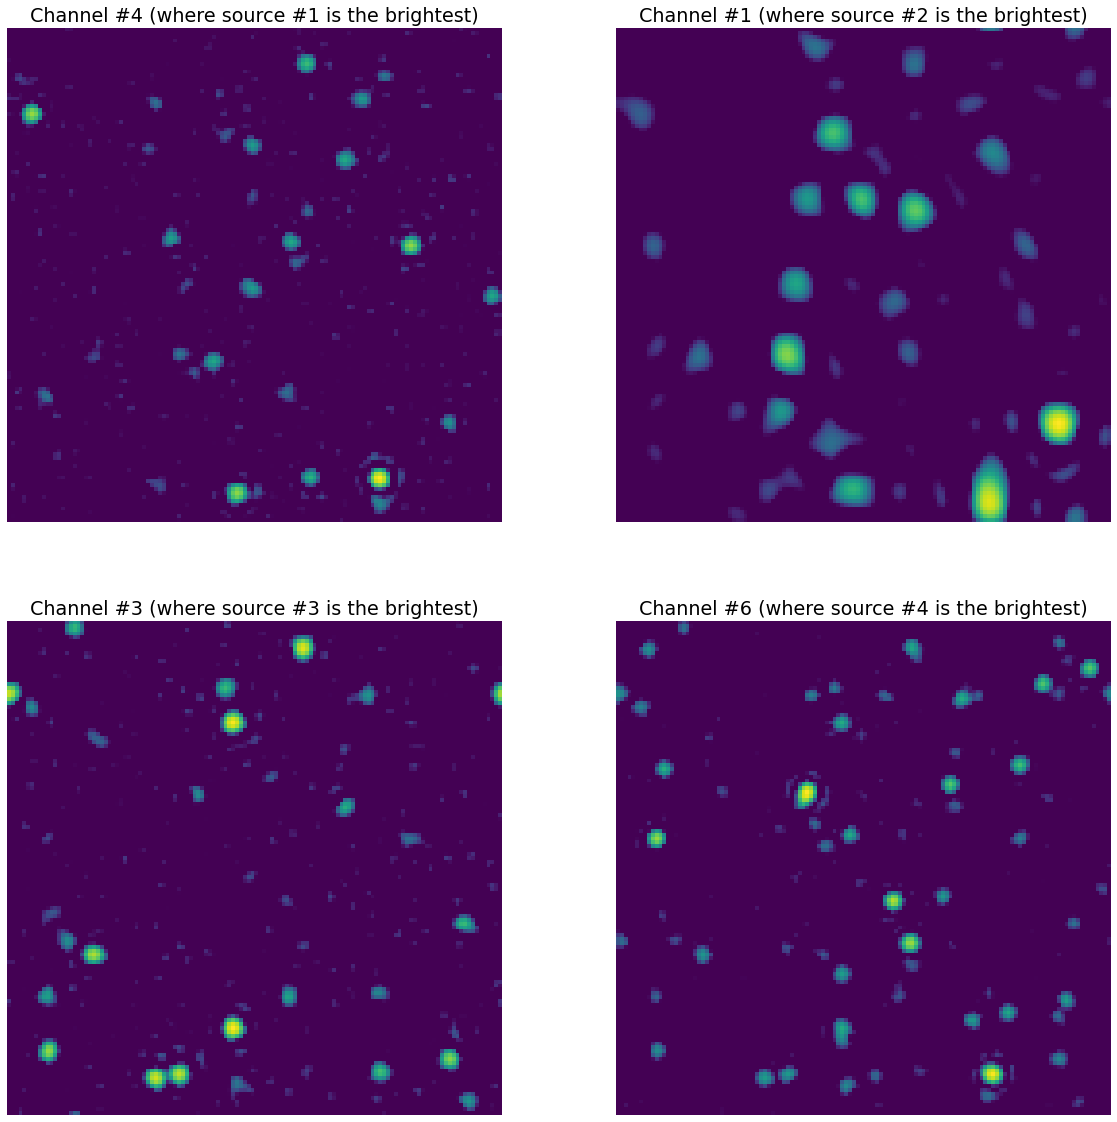

In [15]:
coefs = np.linalg.norm(H, axis=2) / np.sum(np.linalg.norm(H, axis=2), axis=1)[:, np.newaxis]
X_dirty = np.real(np.sum(coefs[:, :, np.newaxis]*fftt.ifft(Y/np.maximum(H, 1e-3))*G[np.newaxis].conj(), axis=1))

channels = np.argmax(A0, axis=0)  # channels where each source emits the most

def f(x):
    return np.log10(np.maximum(vmin,x))

fig = plt.figure(figsize=(20,20))
for i, j in enumerate(range(221, 225)):
    fig.add_subplot(j)
    plt.imshow(np.reshape(f(X_dirty[channels[i], :]), (size, size)))
    plt.title('Channel #%i (where source #%i is the brightest)' % (channels[i]+1, i+1))
    plt.gca().set_axis_off()

# Run wGMCA

In [16]:
wgmca = wGMCA(Y, H, n, Var, G, itCG=50, nscales=nscales, K_max=0.1, H_reconv=H_reconv, verb=verb)

wgmca.run();


  - Number of sources: 4
  - Non-negativity constraint on A and S
  - Minimum number of iterations at warm-up: 50
  - Tikhonov regularization hyperparameter at warm-up: 5.00e-01
  - Tikhonov regularization hyperparameter at refinement: 5.00e-01
  - Noise std estimated with MAD
  - nscales = 3  |  k = 3.00  |  K_max = 10%
  - L1 penalization with L1-reweighting



# Get and plot results

The spectral angular distance (SAD) concerns the mixing matrix. The source normalized mean-square error (NMSE) concerns the sources. The latter can be calculated on sources at the high resolution of the F_max channel or at the low resolution of the F_min channel.

In [17]:
if not wgmca.aborted:
    A, S = utils.corr_perm(A0, wgmca.A, wgmca.S)

    S_reconv = fftt.convolve(S, H_reconv).real
    S0_reconv = fftt.convolve(S0, H_reconv).real
    
    sad = utils.sad(A0, A)
    nmse_low = utils.nmse(S0_reconv, S_reconv)
    nmse_high = utils.nmse(S0, S)
    
    print('SAD : %.2f dB | SNMSE : %.2f dB / %.2f dB (resp. at F_min and F_max)' % (sad, nmse_low, nmse_high))
else:
    print('Error, wGMCA has aborted.')

SAD : 17.05 dB | SNMSE : 14.57 dB / 11.31 dB (resp. at F_min and F_max)


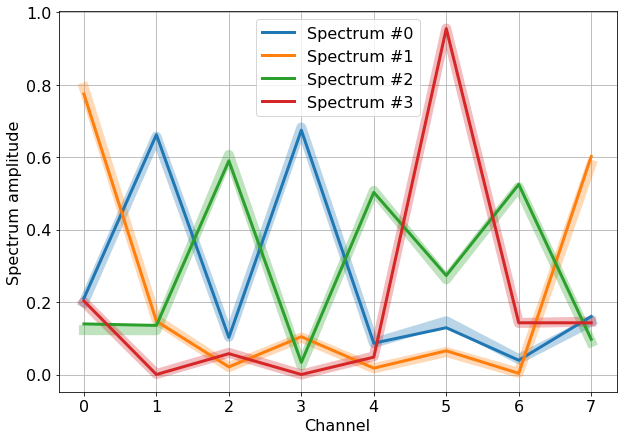

In [18]:
# Plot the mixing matrix

plt.figure(figsize=(10,7))
for i in range(n):
    plt.plot(A0[:, i], 'C%i' % i, linewidth=10, alpha=0.3)
for i in range(n):
    plt.plot(A[:, i], linewidth=3, label='Spectrum #%i' % i)
plt.grid()
plt.legend()
plt.xlabel('Channel')
plt.ylabel('Spectrum amplitude');

### Sources at the (high) resolution of the F_max channel

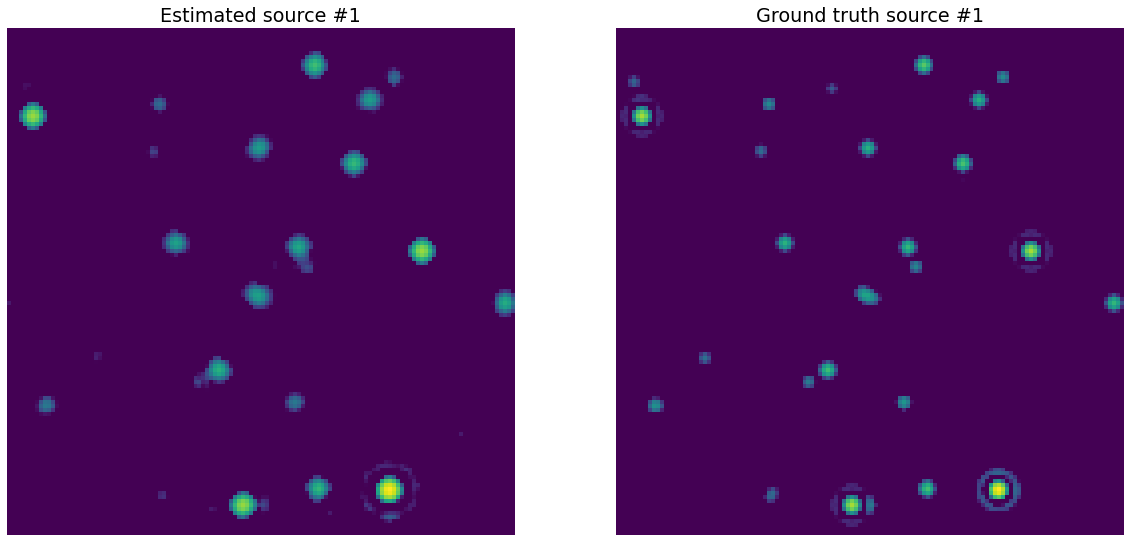

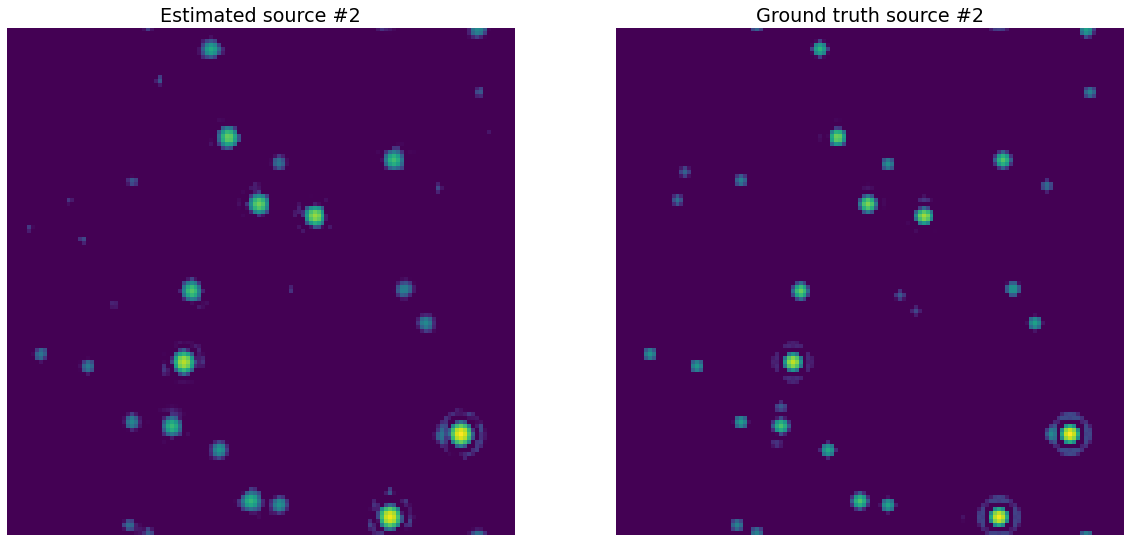

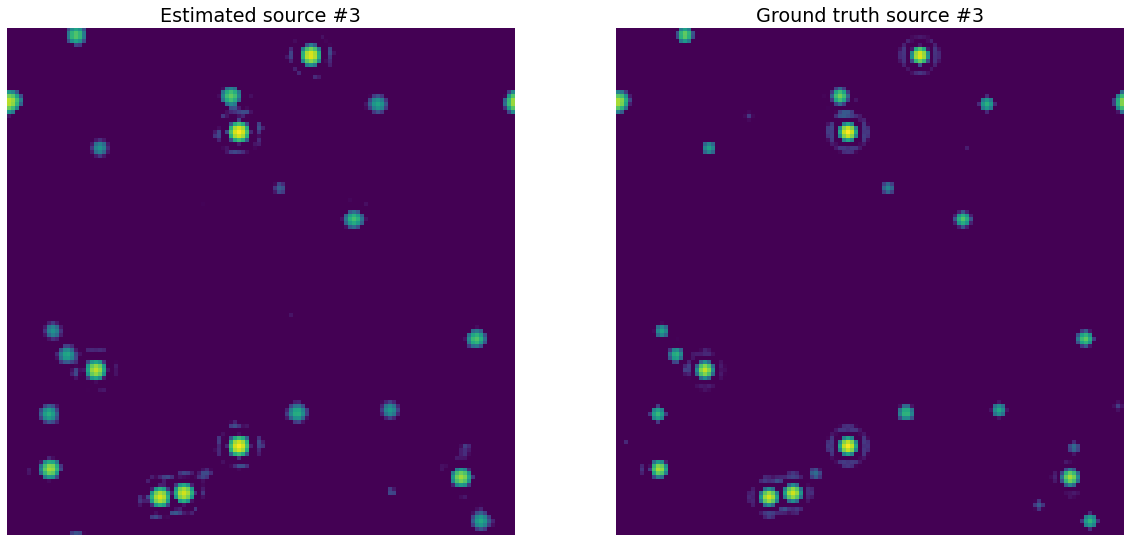

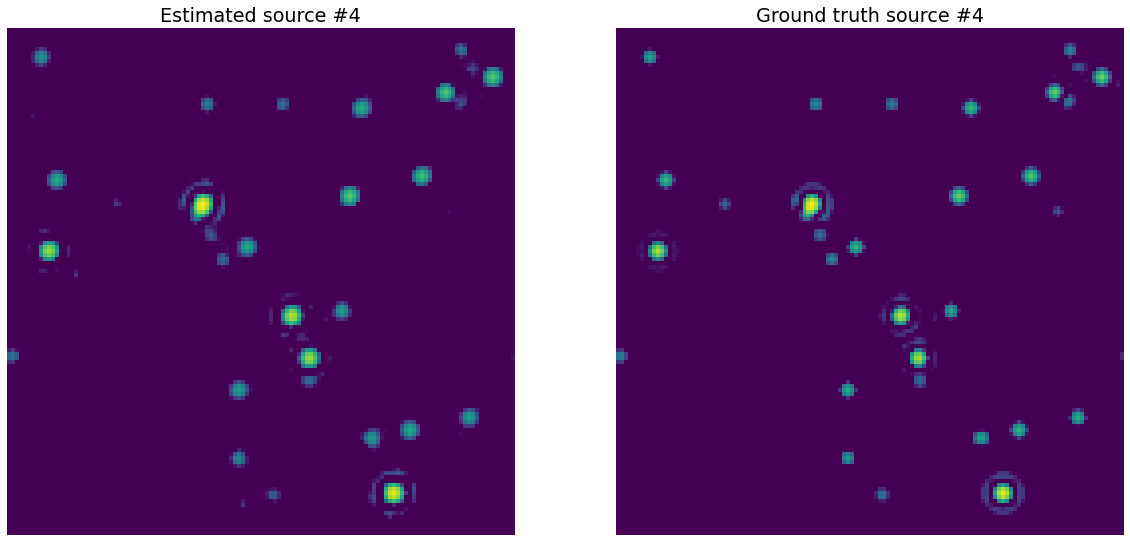

In [19]:
for i in range(n):
    fig = plt.figure(figsize=(20,20))
    fig.add_subplot(121)
    plt.imshow(np.reshape(f(S[i, :]), (size, size)))
    plt.title('Estimated source #%i' % (i+1))
    plt.gca().set_axis_off()
    fig.add_subplot(122)
    plt.imshow(np.reshape(f(S0[i, :]), (size, size)))
    plt.title('Ground truth source #%i' % (i+1))
    plt.gca().set_axis_off()

### Sources at the (low) resolution of the F_min channel

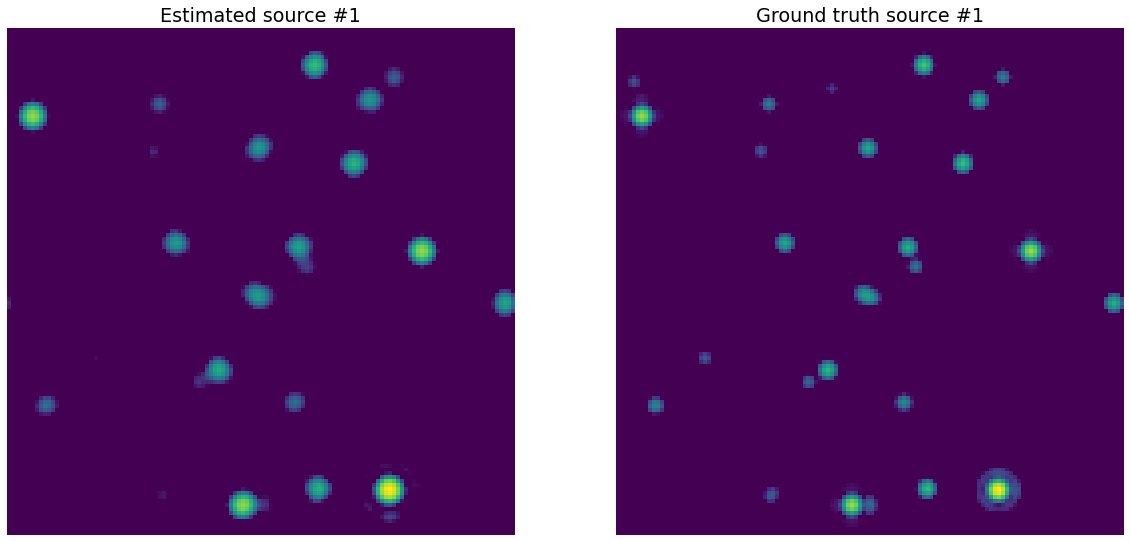

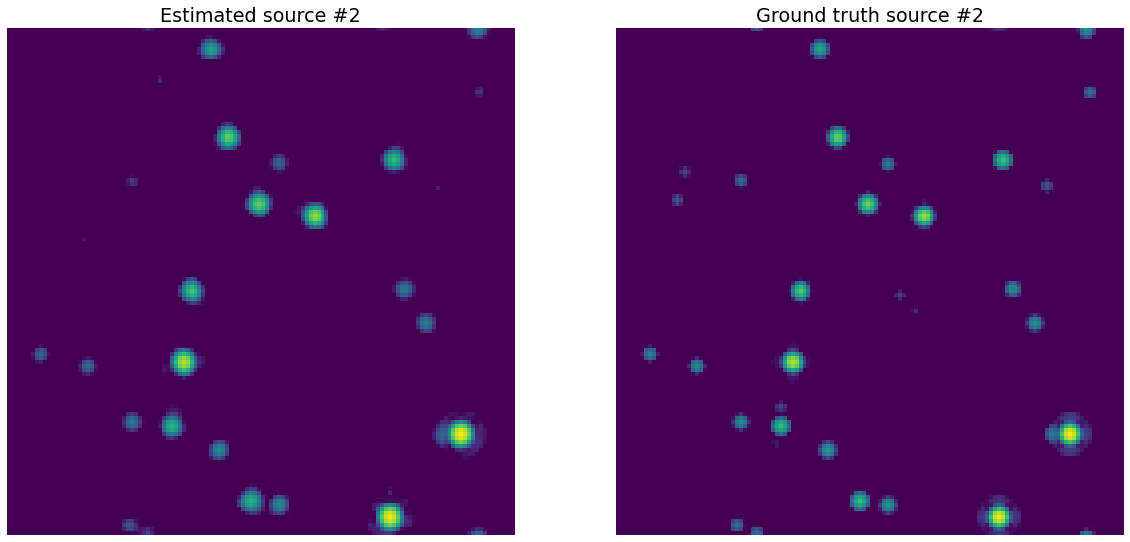

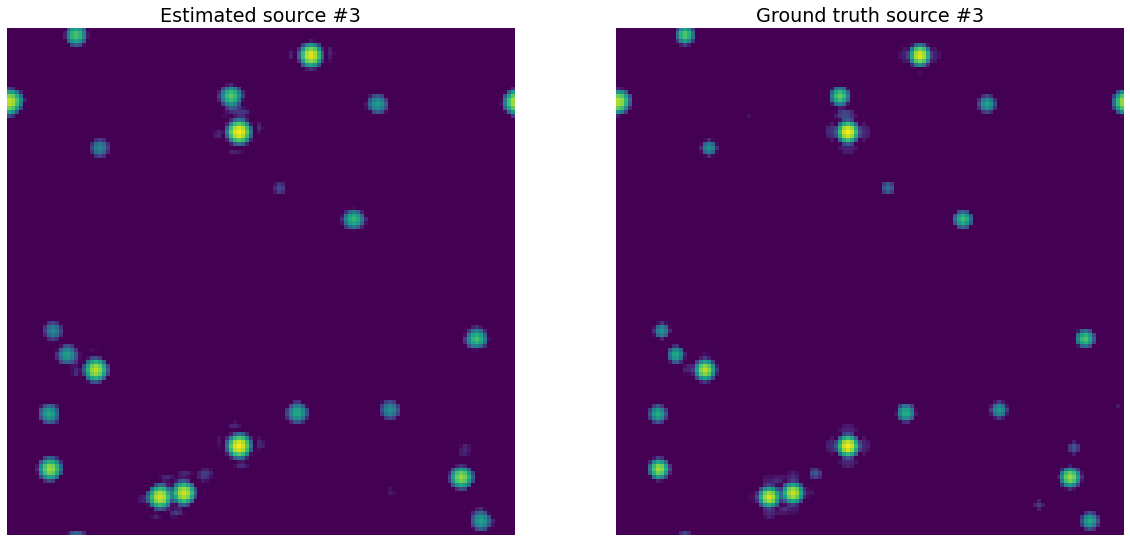

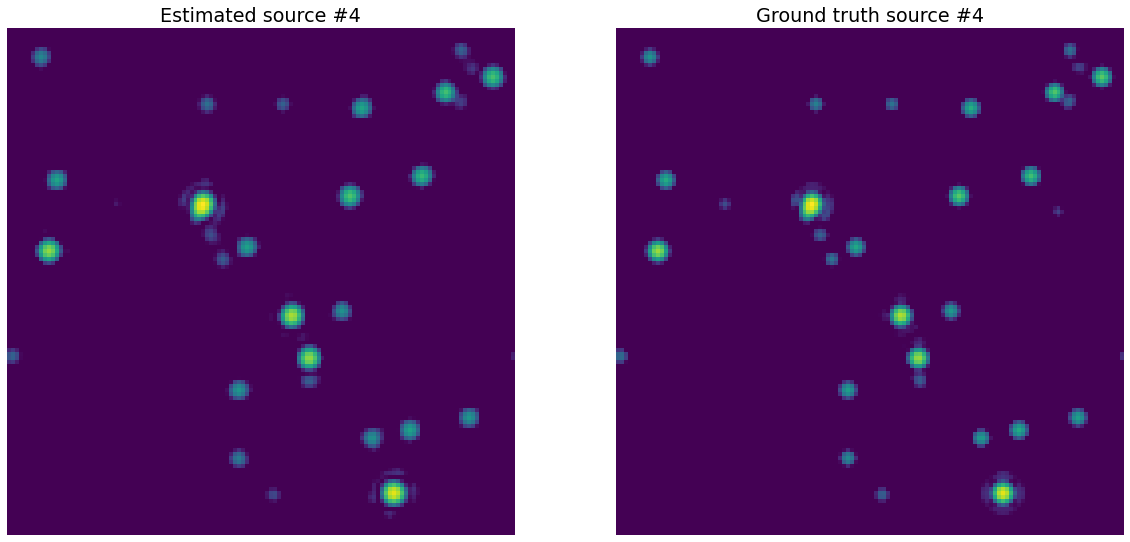

In [20]:
for i in range(n):
    fig = plt.figure(figsize=(20,20))
    fig.add_subplot(121)
    plt.imshow(np.reshape(f(S_reconv[i, :]), (size, size)))
    plt.title('Estimated source #%i' % (i+1))
    plt.gca().set_axis_off()
    fig.add_subplot(122)
    plt.imshow(np.reshape(f(S0_reconv[i, :]), (size, size)))
    plt.title('Ground truth source #%i' % (i+1))
    plt.gca().set_axis_off()